In [1]:
import numpy as np
import pandas as pd
import os

featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(25)

n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)
companies

['22328d65a8ae',
 '695b1e497540',
 'e2415cb7f63d',
 '7cc4ff7756ca',
 '8ded09ca1316',
 '61bbe440bf3e',
 '049fd91f3b99',
 '8b8937c0ca2a']

In [2]:
def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features

,049fd91f3b99_d1,22328d65a8ae_d1,61bbe440bf3e_d1,695b1e497540_d1,7cc4ff7756ca_d1,8b8937c0ca2a_d1,8ded09ca1316_d1,e2415cb7f63d_d1,049fd91f3b99_d2,22328d65a8ae_d2,...,8ded09ca1316_d2,e2415cb7f63d_d2,049fd91f3b99_d1p2,22328d65a8ae_d1p2,61bbe440bf3e_d1p2,695b1e497540_d1p2,7cc4ff7756ca_d1p2,8b8937c0ca2a_d1p2,8ded09ca1316_d1p2,e2415cb7f63d_d1p2
trans_date,,,,,,,,,,,,,,,,,,,,,
2016-01-03,1.331200,-1.722102,-1.731042,-0.953709,0.999516,-0.197762,-0.108332,0.116061,1.487699,-1.861666,...,-1.260831,-0.063094,0.173303,0.541526,0.486385,-0.014256,0.000141,-0.207426,-0.271463,-0.455991
2016-01-04,-0.674696,0.599132,-0.792155,-0.192471,0.824923,0.086920,0.092648,1.199725,-1.177830,1.448468,...,0.115397,0.744286,-0.122082,-0.176466,-0.090239,-0.150815,-0.084822,-0.213989,-0.272532,0.204591
2016-01-05,0.190883,-0.278254,0.295060,-0.034277,-0.577735,-0.122491,-0.816843,0.267706,0.507735,-0.546977,...,-0.520130,-0.639693,-0.215746,-0.253786,-0.222093,-0.156409,-0.177658,-0.212563,-0.090549,-0.428922
2016-01-06,0.192237,-0.089127,-0.092583,-0.163761,-0.293687,0.058012,-0.365272,-0.406391,0.000432,0.118363,...,0.258811,-0.462602,-0.215629,-0.272950,-0.241050,-0.152412,-0.243558,-0.214918,-0.237752,-0.386357
2016-01-07,-0.017433,0.200164,0.348265,0.081296,0.361322,0.111950,-0.455175,-0.097721,-0.123439,0.180850,...,-0.051077,0.212171,-0.223878,-0.264166,-0.213785,-0.155539,-0.231557,-0.212894,-0.217384,-0.458018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-05,-0.026753,0.867947,1.048305,0.823506,-1.464053,0.589447,0.421827,-0.509114,0.208523,0.329546,...,-0.111153,-0.333508,-0.223788,-0.067964,0.023799,-0.050222,0.304488,-0.140213,-0.226306,-0.342963
2022-11-06,-0.193048,-0.820411,-1.450512,-1.058501,0.365764,-0.189813,0.139461,-0.375232,-0.097978,-1.052897,...,-0.161224,0.092161,-0.215629,-0.089716,0.269167,0.018759,-0.230694,-0.208084,-0.269592,-0.397590
2022-11-07,0.194982,-0.192926,-0.334375,-0.369904,0.872455,-0.293469,-1.210612,0.494573,0.227412,0.391831,...,-0.772277,0.597449,-0.215391,-0.264870,-0.215852,-0.135212,-0.063301,-0.197364,0.129321,-0.348708


In [3]:
import tensorflow as tf
import keras
import random
import numpy as np
from data_generation import gen_data
from pyod.utils import pairwise_distances_no_broadcast
from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model_Base
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, temporalize, reconstruction

In [11]:
# total_time = 30000
# seq_size = 25
seq_size = 35
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

lstm_pred, lstm_outliers = lstm_run(
    LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   96,
            64,
            32,
            32,
            64, 
            96
        ], 
        mid_activation=tf.nn.sigmoid
    ),
    data_train_seq,
    data_test_seq,
    batch_size=32,
    epoch=300,
    metric="all",
    early_stopping=False
)
# dense_pred, dense_outliers = dense_run(data_train, data_test, n_feature, batch_size = 100)

print(f"Data test shape {data_test.shape}")
print(f"lstm_pred shape {lstm_pred.shape}")
# print(f"dense_pred shape {dense_pred.shape}")


Epoch 1/300
46/46 [==============================] - 8s 55ms/step - loss: 0.9629
Epoch 2/300
46/46 [==============================] - 2s 52ms/step - loss: 0.9518
Epoch 3/300
46/46 [==============================] - 2s 54ms/step - loss: 0.9453
Epoch 4/300
46/46 [==============================] - 3s 59ms/step - loss: 0.9528
Epoch 5/300
46/46 [==============================] - 3s 58ms/step - loss: 0.9463
Epoch 6/300
46/46 [==============================] - 3s 58ms/step - loss: 0.9430
Epoch 7/300
46/46 [==============================] - 3s 58ms/step - loss: 0.9498
Epoch 8/300
46/46 [==============================] - 3s 57ms/step - loss: 0.9386
Epoch 9/300
46/46 [==============================] - 3s 66ms/step - loss: 0.9455
Epoch 10/300
46/46 [==============================] - 3s 58ms/step - loss: 0.9313
Epoch 11/300
46/46 [==============================] - 3s 69ms/step - loss: 0.9397
Epoch 12/300
46/46 [==============================] - 3s 57ms/step - loss: 0.9401
Epoch 13/300
46/46 [=====

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


31/31 [==============================] - 1s 31ms/step
Data test shape (1002, 24)
lstm_pred shape (1002, 24)


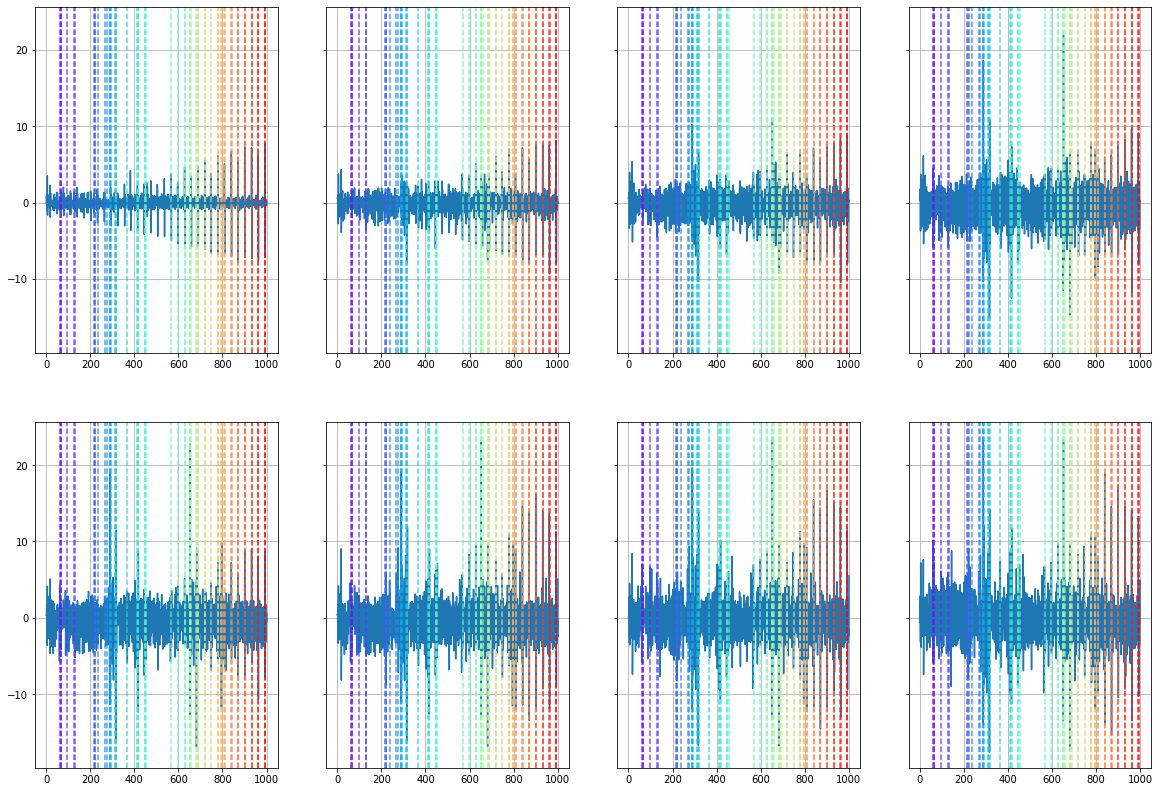

In [15]:
from class_simulationhelper import SimulationHelpers 

sim = SimulationHelpers()
outliers = lstm_outliers["bb"]
sim.plot(
    # *lstm_pred.T[:len(companies)], 
    # *data_test.T[:6],
    *np.cumsum(data_test,axis = 1).T[:n_companies],
    outliers = [outliers for _ in range(n_companies)], 
    row_lim=4
)


TypeError: unsupported type for timedelta days component: str

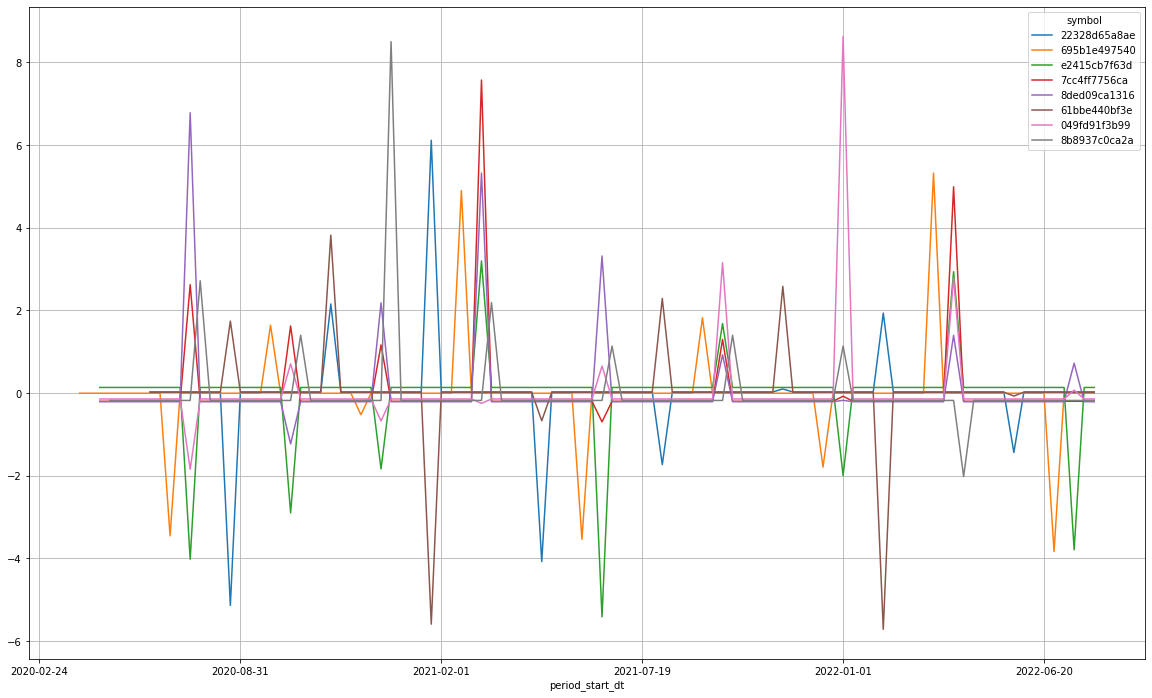

In [19]:
sales = pd.read_csv("data/data4columbia_sales.csv")
date = featured_credit.iloc[partition_size].name
sales = sales.pivot_table(values="reported_sales", index="period_start_dt", columns="symbol")
sales = sales.loc[:,[col for col in companies if col in sales.columns]]

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime, timedelta
fig, ax = plt.subplots()
sales.loc[date:].fillna(method="ffill").diff().apply(lambda x: (x - x.mean())/x.std()).plot(figsize = [20,12], grid = True, ax = ax)
outliers = [(datetime.strptime(date, "%Y-%m-%d") + timedelta(days = d)).strftime("%Y-%m-%d") for d in lstm_outliers]
outliers = [outliers]
print(outliers)
for i, l in enumerate(outliers):
    cmap= iter(cm.rainbow(np.linspace(0, 1, len(l))))
    for point in l:
        ax.axvline(x = pd.Timestamp(point), color = next(cmap), linestyle = "--", alpha = 0.8)

In [7]:
pd.Timestamp("2022-10-01")

Timestamp('2022-10-01 00:00:00')

In [8]:

sales.loc[date:]

symbol,22328d65a8ae,695b1e497540,e2415cb7f63d,7cc4ff7756ca,8ded09ca1316,61bbe440bf3e,049fd91f3b99,8b8937c0ca2a
period_start_dt,,,,,,,,
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,3176.327,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-06-26,NaN,3270.804,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,2440.0,NaN,413.805,NaN,1604.0,NaN


In [1]:
from model_exec import OutlierMetric

metric = OutlierMetric()
x = [1,3,5,6,2,6,6,1,2,3,5,1,5,4, 17]
metric.iqr_outlier(x)

[14]